In [ ]:
!pip install --quiet cirq==1.6.1
!pip install --quiet qsimcirq==0.22.0

In [7]:
import cirq
import qsimcirq
import itertools
import cirq_google
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from cirq.contrib.svg import SVGCircuit


# Overview

This notebook implements a simulation of the Surface Code, one of the leading candidates for Quantum Error Correction (QEC), utilizing the realistic topology and noise models of Google's Willow quantum processor.

The goal is to construct a "Logical Qubit" from a grid of physical qubits, defining data qubits and ancilla qubits to detect errors (syndromes) without collapsing the quantum state.

Key Technical Steps:





1.   **Device Initialization (willow_pink):** Loads the specific geometry, noise properties, and calibration data of the Willow chip using cirq_google.

2.   **Lattice Generation:** Defines a specific patch on the processor grid (Rows 2-7, Cols 4-9) and maps qubits into three roles using a checkerboard pattern:

*   Data Qubits: Store the quantum information.
*   Ancilla X (Yellow): Measure X-stabilizers (phase errors).
*   Ancilla Z (Green): Measure Z-stabilizers (bit-flip errors).

3.   **Logical Operations:** Implements logical operators ($X_L$, $Z_L$) that span the entire patch.

4.   **Stabilizer Cycle:** Constructs the QEC circuit loop, entangling ancillas with data qubits to extract error syndromes via mid-circuit measurements.

5.   **Native Compilation:** Transpiles the theoretical circuit into the device's native gateset (converting standard CNOT/Hadamard into PhasedXZ and CouplerPulse operations).

6.   **Syndrome Extraction:** Executes the circuit on the QVM (Quantum Virtual Machine) to obtain the raw syndrome vector, which is the input for decoding algorithms like Minimum Weight Perfect Matching (MWPM).

# 1°: Basic Processor Configuration

This section initializes the local simulator with the architectural constraints of the willow_pink chip. By loading the device's noise model and calibration data via cirq_google, we create a realistic testbed for our circuits. The ASCII diagram below visualizes the processor's qubit layout and coupling map.

In [9]:
processor_id = "willow_pink"
noise_props = cirq_google.engine.load_device_noise_properties(processor_id)
noise_model = cirq_google.NoiseModelFromGoogleNoiseProperties(noise_props)
qsim = qsimcirq.QSimSimulator(noise=noise_model)

In [10]:
device = cirq_google.engine.create_device_from_processor_id(processor_id)
cal = cirq_google.engine.load_median_device_calibration(processor_id)
sim_processor = cirq_google.engine.SimulatedLocalProcessor(
    processor_id=processor_id,
    sampler=qsim,
    device=device,
    calibrations={cal.timestamp // 1000: cal}
)
sim_engine = cirq_google.engine.SimulatedLocalEngine([sim_processor])

In [11]:
print(sim_engine.get_processor(processor_id).get_device())

                                                        (0, 6)────(0, 7)────(0, 8)
                                                        │         │         │
                                                        │         │         │
                                              (1, 5)────(1, 6)────(1, 7)────(1, 8)
                                              │         │         │         │
                                              │         │         │         │
                                    (2, 4)────(2, 5)────(2, 6)────(2, 7)────(2, 8)────(2, 9)────(2, 10)
                                    │         │         │         │         │         │         │
                                    │         │         │         │         │         │         │
                           (3, 3)───(3, 4)────(3, 5)────(3, 6)────(3, 7)────(3, 8)────(3, 9)────(3, 10)
                           │        │         │         │         │         │         │         │
                    

# 2°: Extraction of the Grid to be used by the Surface Code

Here, we carve out a subset of the processor to run the Surface Code. We iterate through the grid coordinates to classify qubits into Data and Ancilla (measurement) qubits.

The resulting graph visualization confirms the physical topology:


*   Gray Nodes: Data Qubits.
*   Green/Yellow Nodes: Measurement Ancillas for Z and X error syndromes. This connectivity map is crucial for defining the stabilizer circuits in the next steps.



In [12]:
willow_grid = []


for i in range(2, 7):
  row = []
  for j in range(4, 9):
    row.append((i, j))
  willow_grid.append(row)

print("Selected qubits for simulating an surface code")
willow_grid

Selected qubits for simulating an surface code


[[(2, 4), (2, 5), (2, 6), (2, 7), (2, 8)],
 [(3, 4), (3, 5), (3, 6), (3, 7), (3, 8)],
 [(4, 4), (4, 5), (4, 6), (4, 7), (4, 8)],
 [(5, 4), (5, 5), (5, 6), (5, 7), (5, 8)],
 [(6, 4), (6, 5), (6, 6), (6, 7), (6, 8)]]

In [13]:
grid_flat = [coord for row in willow_grid for coord in row]
data_qubit = []
anc_x = []
anc_z = []

for (r, c) in grid_flat:
    if (r + c) % 2 == 0:
        data_qubit.append((r, c))
    elif r % 2 == 0:
        anc_z.append((r, c))
    else:
        anc_x.append((r, c))

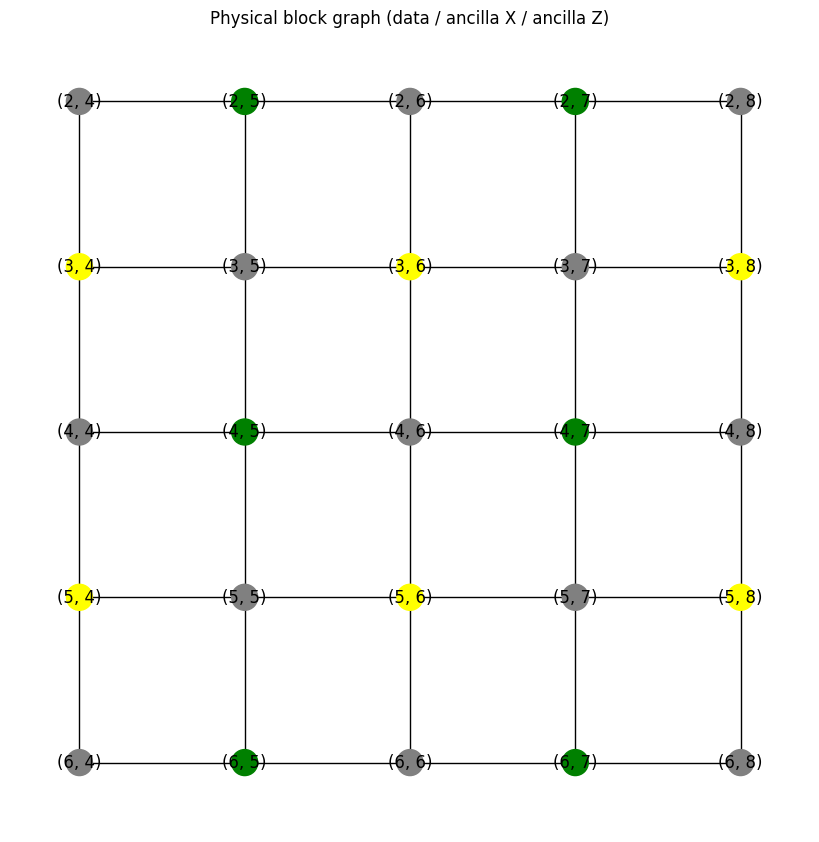

In [14]:
G = nx.Graph()
for (r, c) in grid_flat:
    G.add_node((r, c))

for (r, c) in grid_flat:
    for dr, dc in [(1,0), (-1,0), (0,1), (0,-1)]:
        neighbor = (r+dr, c+dc)
        if neighbor in grid_flat:
            G.add_edge((r, c), neighbor)

color_map = []
for n in G.nodes():
    if n in data_qubit:
        color_map.append('gray')
    elif n in anc_x:
        color_map.append('yellow')
    elif n in anc_z:
        color_map.append('green')
    else:
        color_map.append('gray')

pos = { n: (n[1], -n[0]) for n in G.nodes() }

plt.figure(figsize=(8,8))
nx.draw(G, pos, with_labels=True, node_color=color_map, node_size=350)
plt.title('Physical block graph (data / ancilla X / ancilla Z)')
plt.show()


# 3°: Code Measurement Cycle Build and Logical Gates

In this section, we transition from physical qubit layout to logical qubit definitions. We implement two critical components of the Surface Code:



1.   **Logical Operators ($X_L$, $Z_L$):**
We define the logical states by operating on chains of physical qubits that span the lattice.

*   **Logical X ($X_L$):** Implemented by applying physical X gates along a vertical chain of data qubits (e.g., columns spanning from top to bottom).

*   **Logical Z ($Z_L$):** Implemented by applying physical Z gates along a horizontal chain.


2.  **The Stabilizer Cycle:** The build_surface_code_cycle() function constructs the quantum circuit required for one round of error correction. It performs the following sequence:

*   **Preparation:** X-ancillas are initialized into the $|+\rangle$ state using Hadamard gates.

*  **Entanglement:** CNOT gates are applied between ancillas and their neighboring data qubits to map parity information onto the ancillas.

*  **Measurement:** Ancillas are measured to extract the syndrome (diagnosis of errors), while data qubits remain unmeasured to preserve the superposition.

Finally, we verify the implementation by building a circuit that applies a Logical X followed by one stabilizer cycle, visualizing the complex sequence of gates using SVGCircuit.


In [15]:
# Convert coordinates to cirq.GridQubit
data_qubits = [cirq.GridQubit(r, c) for (r, c) in data_qubit]
anc_x_qubits = [cirq.GridQubit(r, c) for (r, c) in anc_x]
anc_z_qubits = [cirq.GridQubit(r, c) for (r, c) in anc_z]
grid_qubits = [cirq.GridQubit(r, c) for (r, c) in grid_flat]

In [16]:
# explicit data string where logical operators should be applied.
vertical_chain = [
        cirq.GridQubit(2, 4),
        cirq.GridQubit(4, 4),
        cirq.GridQubit(6, 4)
    ]

horizontal_chain = [
        cirq.GridQubit(2, 4),
        cirq.GridQubit(2, 6),
        cirq.GridQubit(2, 8)
    ]

In [17]:
# Apply a logical X
def logical_x_vertical(circuit):
    """
    Applies the logical X (X_L) by acting on a vertical chain of n data qubits
    spanning the patch from top to bottom.
    """
    for q in vertical_chain:
        circuit.append(cirq.X(q))


# Apply a logical Z
def logical_z_horizontal(circuit):
    """
    Applies the logical Z (Z_L) by acting on a horizontal chain of n data qubits
    spanning the patch from left to right.
    """
    for q in horizontal_chain:
        circuit.append(cirq.Z(q))


# Stabilizer cycle construction
def neighbors(q, grid):
    nbrs = []
    for dr, dc in [(1, 0), (-1, 0), (0,1), (0,-1)]:
        cand = cirq.GridQubit(q.row+dr, q.col+dc)
        if cand in grid and cand in data_qubits:
            nbrs.append(cand)
    return nbrs

def build_surface_code_cycle():
    circ = cirq.Circuit()

    # ——— Prepare ancilla qubits ———
    # X-type ancillas |+> Hadamard
    for q in anc_x_qubits:
        circ.append(cirq.H(q))

    # Z-type ancillas already begin in |0>

    # ——— CNOTs for X Stabilizers ———
    for q in anc_x_qubits:
        for d in neighbors(q, grid_qubits):
            circ.append(cirq.CNOT(q, d))

    # ——— CNOTs for Z Stabilizers ———
    for q in anc_z_qubits:
        for d in neighbors(q, grid_qubits):
            circ.append(cirq.CNOT(d, q))

    # ——— Measurements ———

    # X Measurements: Apply H and measure
    for q in anc_x_qubits:
        circ.append(cirq.H(q))
        circ.append(cirq.measure(q, key=f"mX_{q.row}_{q.col}"))

    # Z Measurements: Measure directly in Z
    for q in anc_z_qubits:
        circ.append(cirq.measure(q, key=f"mZ_{q.row}_{q.col}"))

    return circ

In [18]:
circuit = cirq.Circuit()

# Apply a logical X
logical_x_vertical(circuit)


# Add one stabilizer cycle
circuit += build_surface_code_cycle()


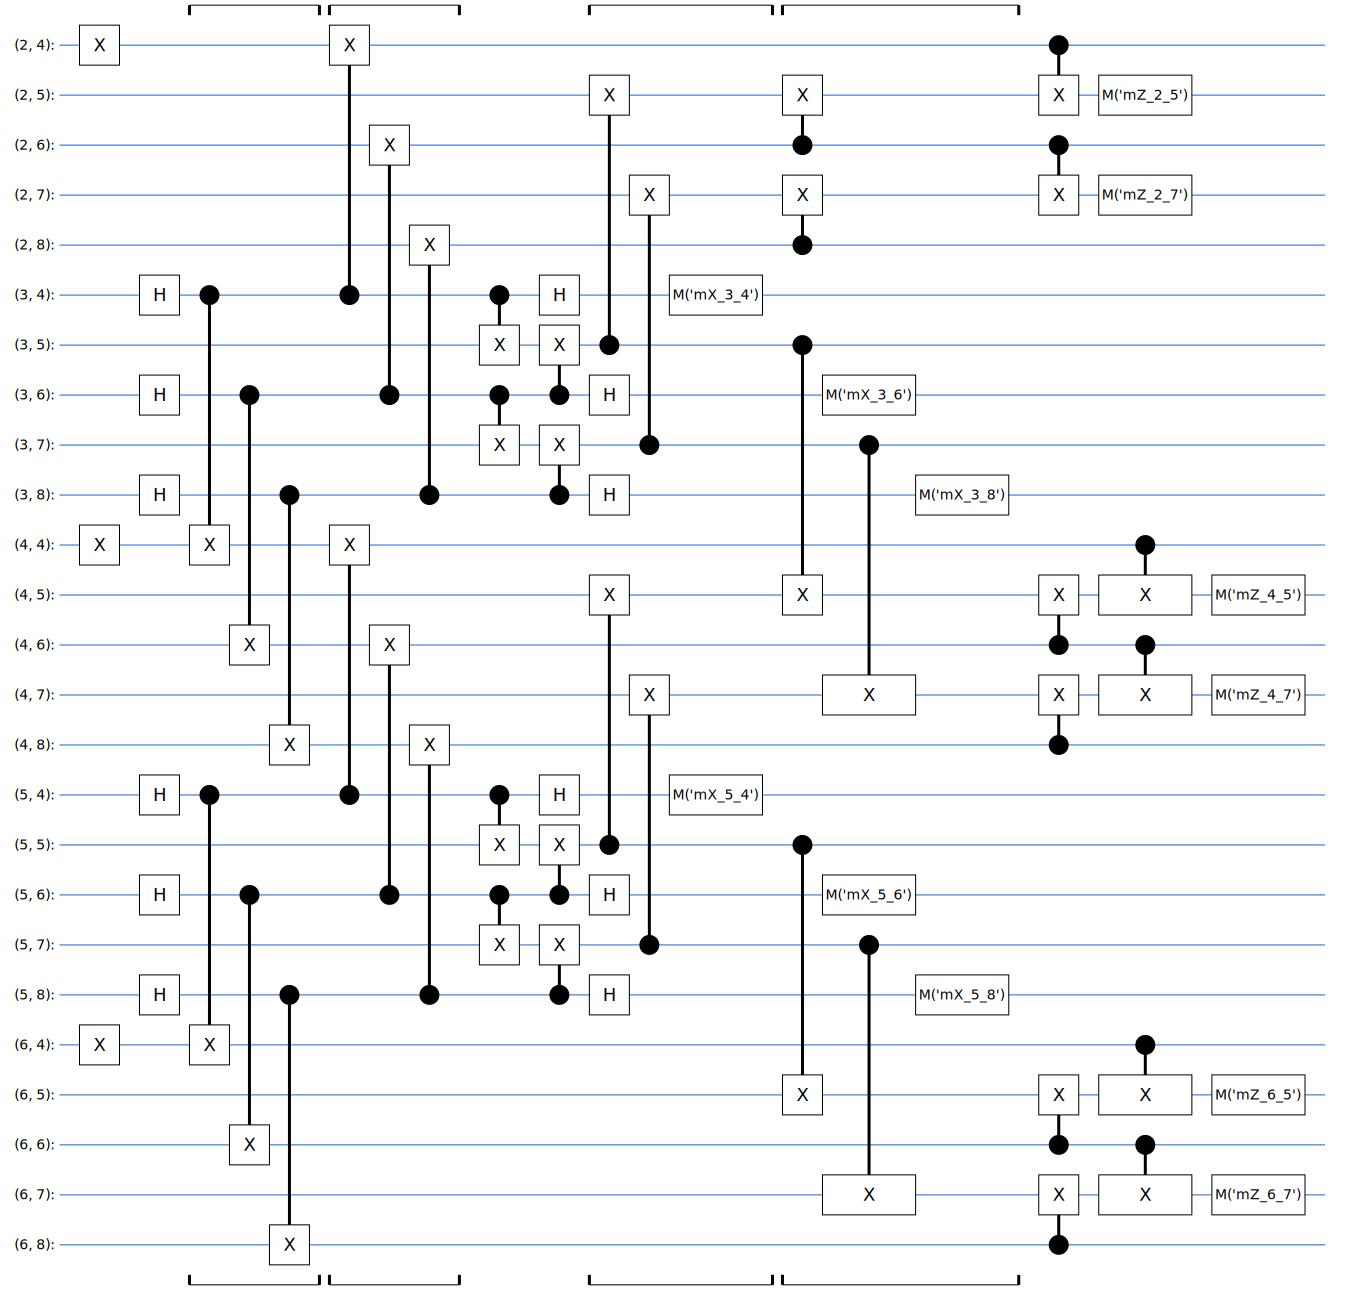

In [19]:
SVGCircuit(circuit)

# 4°: Transpiling the circuit

Abstract quantum circuits (using H, CNOT, etc.) cannot be executed directly on physical hardware. The Willow processor operates using a specific set of physical instructions known as its Native Gateset.

In this step, we perform circuit transpilation:



1.   We retrieve the `compilation_target_gatesets` from the device metadata.
2.   We use `cirq.optimize_for_target_gateset` to convert our logical Surface Code circuit into an equivalent sequence of physical operations supported by the hardware.

The resulting diagram shows the transformed circuit, now composed of PhasedXZ gates (single-qubit rotations) and hardware-specific two-qubit couplers, ready for execution on the simulator.



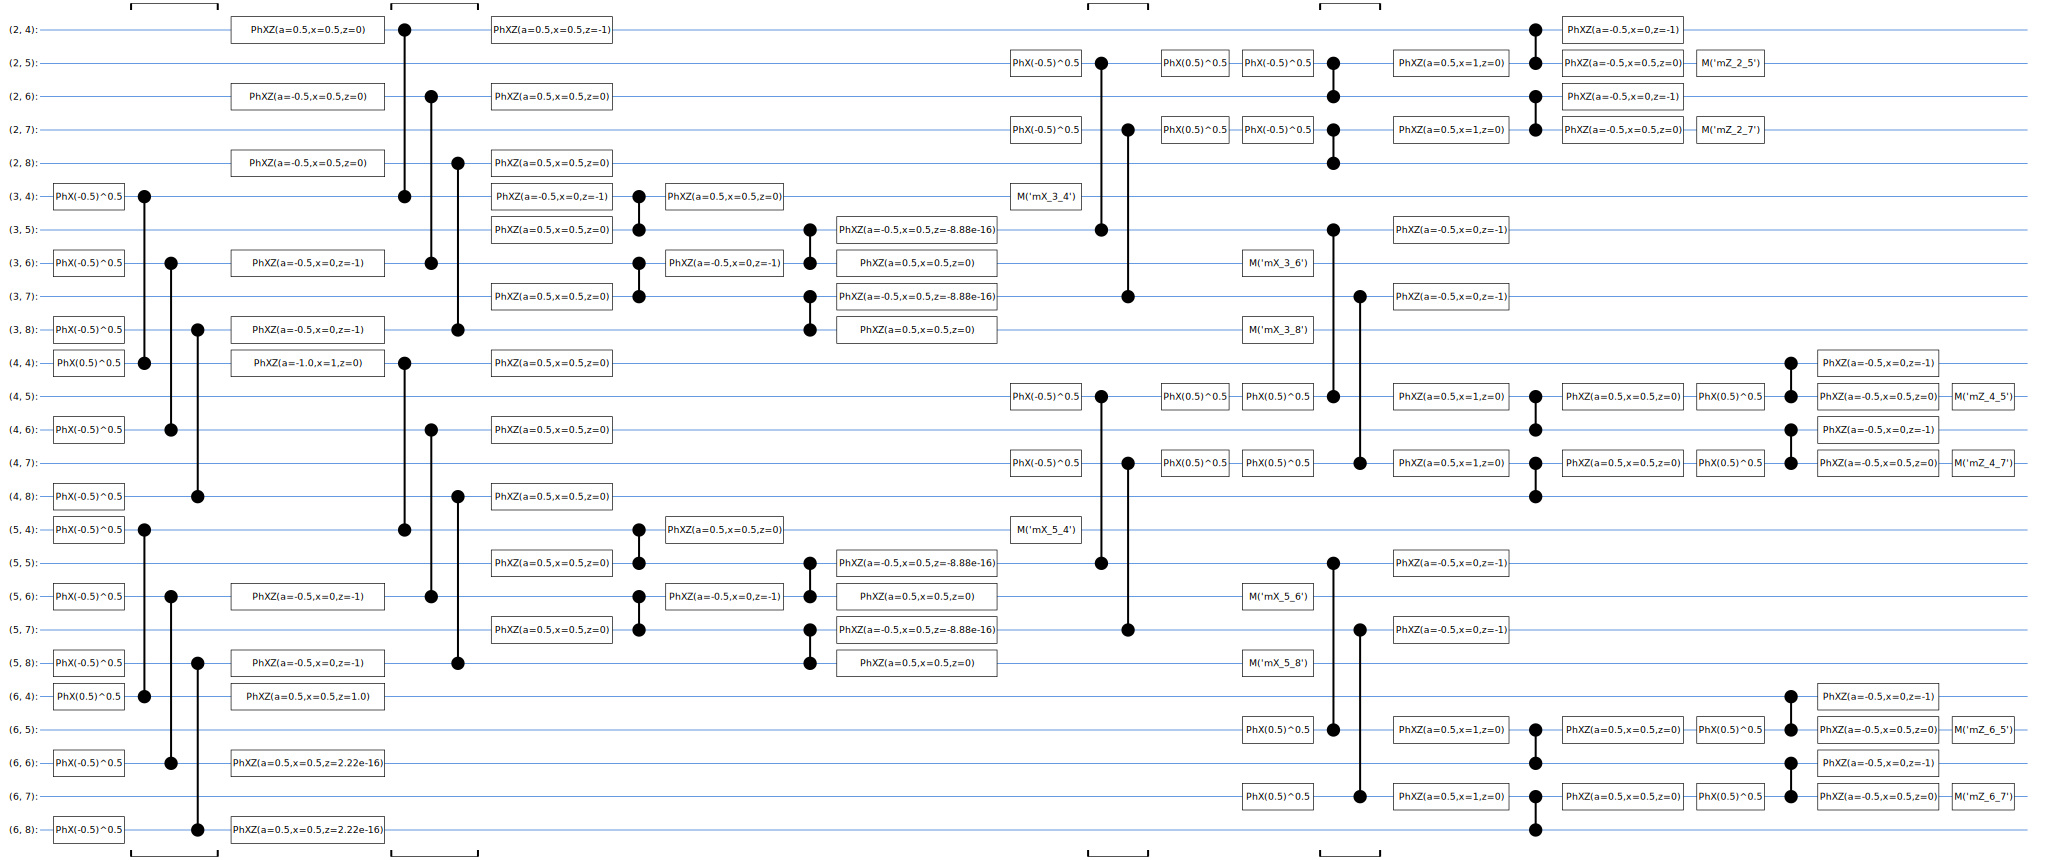

In [20]:
device = sim_engine.get_processor(processor_id).get_device()
target_gateset = device.metadata.compilation_target_gatesets[0]

circuit_native = cirq.optimize_for_target_gateset(
    circuit,
    gateset=target_gateset
)

SVGCircuit(circuit_native)

# 5°: Execute the circuit for the measurement qubits

Finally, we execute the compiled circuit on the simulated Willow processor using the sim_engine sampler.

The process involves:

1.  **Sampling:** We run the circuit (`repetitions=1`) to perform a single-shot experiment of the stabilizer cycle.

2.  **Data Processing:** The raw measurement results returned by the device are keyed by their measurement strings (e.g., `mX_3_4`, `mZ_2_5`).

3.  **Vectorization:** We iterate through these results to construct the Syndrome Vector.

This final vector (a sequence of `0`s and `1`s) represents the parity check outcomes. In a full QEC loop, this vector would be passed to a classical decoder (like MWPM) to identify and correct physical errors based on the observed symptoms.


In [21]:
repetitions = 1

In [22]:
# Get the sampler from the QVM local engine
sampler = sim_engine.get_sampler(processor_id)

# Run the circuit with the desired number of repetitions
results = sampler.run(circuit_native, repetitions=repetitions)

In [23]:
print(results)

mX_3_4=1
mX_3_6=0
mX_3_8=1
mX_5_4=0
mX_5_6=0
mX_5_8=1
mZ_2_5=1
mZ_2_7=0
mZ_4_5=1
mZ_4_7=0
mZ_6_5=1
mZ_6_7=0


In [24]:
syndromes = defaultdict(list)
for key, vals in results.measurements.items():
    syndromes[key].extend(vals.flatten().tolist())

print("Raw syndrome dict keys:", list(syndromes.keys()))

syndrome_keys = sorted(syndromes.keys())
syndrome_vector = [syndromes[k][0] for k in syndrome_keys]

print("Syndrome vector:", syndrome_vector)

Raw syndrome dict keys: ['mX_5_4', 'mX_3_4', 'mX_5_8', 'mX_3_8', 'mX_5_6', 'mX_3_6', 'mZ_2_5', 'mZ_2_7', 'mZ_4_5', 'mZ_6_5', 'mZ_4_7', 'mZ_6_7']
Syndrome vector: [1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0]
